# AMICI Python example "steadystate"

This is an example using the [model_steadystate_scaled.sbml] model to demonstrate and test SBML import and AMICI Python interface.

In [1]:
# SBML model we want to import
sbml_file = 'model_steadystate_scaled.xml'
# Name of the model that will also be the name of the python module
model_name = 'model_steadystate_scaled'
# Directory to which the generated model code is written
model_output_dir = model_name

import libsbml
import importlib
import amici
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

## The example model

Here we use `libsbml` to show the reactions and species described by the model (this is independent of AMICI).

In [2]:
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()
dir(sbml_doc)

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                         products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Importing an SBML model, compiling and generating an AMICI module

Before we can use AMICI to simulate our model, the SBML model needs to be translated to C++ code. This is done by `amici.SbmlImporter`.

In [3]:
# Create an SbmlImporter instance for our SBML model
sbml_importer = amici.SbmlImporter(sbml_file)

In this example, we want to specify fixed parameters, observables and a $\sigma$ parameter. Unfortunately, the latter two are not part of the [SBML standard](http://sbml.org/). However, they can be provided to `amici.SbmlImporter.sbml2amici` as demonstrated in the following.

### Constant parameters

Constant parameters, i.e. parameters with respect to which no sensitivities are to be computed (these are often parameters specifying a certain experimental condition) are provided as a list of parameter names.

In [4]:
constantParameters = ['k0']

### Observables

Specifying observables is beyond the scope of SBML. Here we define them manually.

If you are looking for a more scalable way for defining observables, ideally inside the SBML file, then checkout https://github.com/ICB-DCM/PEtab. There use a convention based on SBML's [`AssignmentRule`](http://sbml.org/Software/libSBML/5.13.0/docs//python-api/classlibsbml_1_1_rule.html) to specify *Model outputs* within the SBML file.

In [5]:
# Define observables
observables = {
    'observable_x1': {'name': '', 'formula': 'x1'}, 
    'observable_x2': {'name': '', 'formula': 'x2'}, 
    'observable_x3': {'name': '', 'formula': 'x3'}, 
    'observable_x1_scaled': {'name': '', 'formula': 'scaling_x1 * x1'}, 
    'observable_x2_offsetted': {'name': '', 'formula': 'offset_x2 + x2'}, 
    'observable_x1withsigma': {'name': '', 'formula': 'x1'}
}

### $\sigma$ parameters

To specify measurement noise as a parameter, we simply provide a dictionary with (preexisting) parameter names as keys and a list of observable names as values to indicate which sigma parameter is to be used for which observable.

In [6]:
sigmas = {'observable_x1withsigma': 'observable_x1withsigma_sigma'}

### Generating the module

Now we can generate the python module for our model. `amici.SbmlImporter.sbml2amici` will symbolically derive the sensitivity equations, generate C++ code for model simulation, and assemble the python module. Standard logging verbosity levels can be passed to this function to see timestamped progression during code generation.

In [7]:
import logging
sbml_importer.sbml2amici(model_name, 
                         model_output_dir, 
                         verbose=logging.INFO,
                         observables=observables,
                         constant_parameters=constantParameters,
                         sigmas=sigmas)

2020-04-24 12:00:42.746 - amici.sbml_import - INFO - Finished processing SBML parameters            (5.40E-04s)
2020-04-24 12:00:42.748 - amici.sbml_import - INFO - Finished processing SBML compartments          (4.23E-04s)
2020-04-24 12:00:42.809 - amici.sbml_import - INFO - Finished processing SBML species               (6.01E-02s)
2020-04-24 12:00:42.819 - amici.sbml_import - INFO - Finished processing SBML reactions             (1.00E-02s)
2020-04-24 12:00:42.847 - amici.sbml_import - INFO - Finished processing SBML rules                 (2.74E-02s)
2020-04-24 12:00:42.928 - amici.sbml_import - INFO - Finished processing SBML observables           (7.94E-02s)
2020-04-24 12:00:43.022 - amici.ode_export - INFO - Finished writing J.cpp                          (4.21E-02s)
2020-04-24 12:00:43.032 - amici.ode_export - INFO - Finished writing JB.cpp                         (8.60E-03s)
2020-04-24 12:00:43.036 - amici.ode_export - INFO - Finished writing JDiag.cpp                      (3.5

### Importing the module and loading the model

If everything went well, we need to add the previously selected model output directory to our PYTHON_PATH and are then ready to load newly generated model:

In [8]:
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)

And get an instance of our model from which we can retrieve information such as parameter names:

In [9]:
model = model_module.getModel()

print("Model name:", model.getName())
print("Model parameters:", model.getParameterIds())
print("Model outputs:   ", model.getObservableIds())
print("Model states:    ", model.getStateIds())

Model name: model_steadystate_scaled
Model parameters: ('p1', 'p2', 'p3', 'p4', 'p5', 'scaling_x1', 'offset_x2', 'observable_x1withsigma_sigma')
Model outputs:    ('observable_x1', 'observable_x2', 'observable_x3', 'observable_x1_scaled', 'observable_x2_offsetted', 'observable_x1withsigma')
Model states:     ('x1', 'x2', 'x3')


### Using the python-generated AMICI model from Matlab

It is also possible to use a Python-AMICI imported model from Matlab. You might want to do this because:
- you don't have the Symbolic Math Toolbox available
- model generation using the AMICI Python interface can be significantly faster
- python SBML import has some extra features that are not available through the matlab interface
- model equations will differ between Python- and Matlab-import

In [10]:
print('''To use python-generated model in Matlab, ensure you added AMICI to your matlab path and run:

modelName = '{model_name}';
modelDir = '{model_output_dir}';
amimodel.compileAndLinkModel(modelName, modelDir, [], [], [], []);
amimodel.generateMatlabWrapper({nx}, {ny}, {np}, {nk}, {nz}, {o2flag}, [], [ modelDir '/simulate_' modelName '.m'], modelName, 'lin', 1, 1);
'''.format(model_name=model_name, 
           model_output_dir=os.path.abspath(model_output_dir),
           nx = model.nxtrue_rdata,
           ny = model.nytrue,
           np = model.np(),
           nk = model.nk(),
           nz = model.nz,
           o2flag = model.o2mode
          ))

To use python-generated model in Matlab, ensure you added AMICI to your matlab path and run:

modelName = 'model_steadystate_scaled';
modelDir = '/Users/ffroehlich/Documents/GitHub/AMICI/python/examples/example_steadystate/model_steadystate_scaled';
amimodel.compileAndLinkModel(modelName, modelDir, [], [], [], []);
amimodel.generateMatlabWrapper(3, 6, 8, 1, 0, 0, [], [ modelDir '/simulate_' modelName '.m'], modelName, 'lin', 1, 1);



This will use the matlab compiler to generate a mex file and will create a Matlab wrapper script. You have to run this only once after generating the Python model. Afterwards you can use the model from Matlab just as if it was generted using `amiwrap.m` directly.

## Running simulations and analyzing results

After importing the model, we can run simulations using `amici.runAmiciSimulation`. This requires a `Model` instance and a `Solver` instance. Optionally you can provide measurements inside an `ExpData` instance, as shown later in this notebook.

In [11]:
# Create Model instance
model = model_module.getModel()

# set timepoints for which we want to simulate the model
model.setTimepoints(np.linspace(0, 60, 60)) 

# Create solver instance
solver = model.getSolver()

# Run simulation using default model parameters and solver options
rdata = amici.runAmiciSimulation(model, solver)

In [12]:
print('Simulation was run using model default parameters as specified in the SBML model:')
print(model.getParameters())

Simulation was run using model default parameters as specified in the SBML model:
(1.0, 0.5, 0.4, 2.0, 0.1, 2.0, 3.0, 0.2)


Simulation results are provided as `numpy.ndarray`s in the returned dictionary:

In [13]:
#np.set_printoptions(threshold=8, edgeitems=2)
for key, value in rdata.items():
    print('%12s: ' % key, value)

          ts:  [ 0.          1.01694915  2.03389831  3.05084746  4.06779661  5.08474576
  6.10169492  7.11864407  8.13559322  9.15254237 10.16949153 11.18644068
 12.20338983 13.22033898 14.23728814 15.25423729 16.27118644 17.28813559
 18.30508475 19.3220339  20.33898305 21.3559322  22.37288136 23.38983051
 24.40677966 25.42372881 26.44067797 27.45762712 28.47457627 29.49152542
 30.50847458 31.52542373 32.54237288 33.55932203 34.57627119 35.59322034
 36.61016949 37.62711864 38.6440678  39.66101695 40.6779661  41.69491525
 42.71186441 43.72881356 44.74576271 45.76271186 46.77966102 47.79661017
 48.81355932 49.83050847 50.84745763 51.86440678 52.88135593 53.89830508
 54.91525424 55.93220339 56.94915254 57.96610169 58.98305085 60.        ]
           x:  [[0.1        0.4        0.7       ]
 [0.57995052 0.73365809 0.0951589 ]
 [0.55996496 0.71470091 0.0694127 ]
 [0.5462855  0.68030366 0.06349394]
 [0.53561883 0.64937432 0.05923555]
 [0.52636487 0.62259567 0.05568686]
 [0.51822013 0.59943346

### A note on datatypes

You might have wondered about expression such as `rdata['y'].flatten()` or `amici.ExpData(model.get())`. This is currently required to convert between Python data types and internal C++ datatypes. The [SWIG](http://swig.org/) interface does not yet do this conversion automatically.

In [14]:
print(model.getParameters())

(1.0, 0.5, 0.4, 2.0, 0.1, 2.0, 3.0, 0.2)


### Plotting tractories

The simulation results above did not look too appealing. Let's plot the trajectories of the model states and outputs  them using `matplotlib.pyplot`:

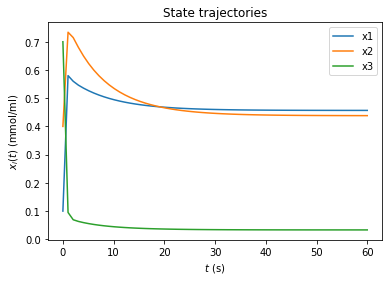

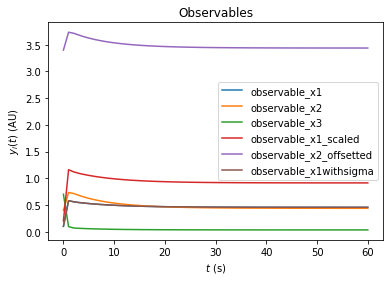

In [15]:
import amici.plotting
amici.plotting.plotStateTrajectories(rdata, model = model)
amici.plotting.plotObservableTrajectories(rdata, model = model)

### Computing likelihood

Often model parameters need to be inferred from experimental data. This is commonly done by maximizing the likelihood of of observing the data given to current model parameters. AMICI will compute this likelihood if experimental data is provided to `amici.runAmiciSimulation` as optional third argument. Measurements along with their standard deviations are provided through an `amici.ExpData` instance.

In [16]:
# Create model instance and set time points for simulation
model = model_module.getModel()
model.setTimepoints(np.linspace(0, 10, 11)) 

# Create solver instance, keep default options
solver = model.getSolver()

# Run simulation without experimental data
rdata = amici.runAmiciSimulation(model, solver)

# Create ExpData instance from simulation results
edata = amici.ExpData(rdata, 1.0, 0.0)

# Re-run simulation, this time passing "experimental data"
rdata = amici.runAmiciSimulation(model, solver, edata)

print('Log-likelihood %f' % rdata['llh'])

Log-likelihood -86.872839


### Simulation tolerances
Numerical error tolerances are often critical to get accurate results. For the state variables, integration errors can be controlled using `setRelativeTolerance` and `setAbsoluteTolerance`. Similar functions exist for sensitivies, steadstates and quadratures. We initially compute a reference solution using extremely low tolerances and then assess the influence on integration error for different levels of absolute and relative tolerance.

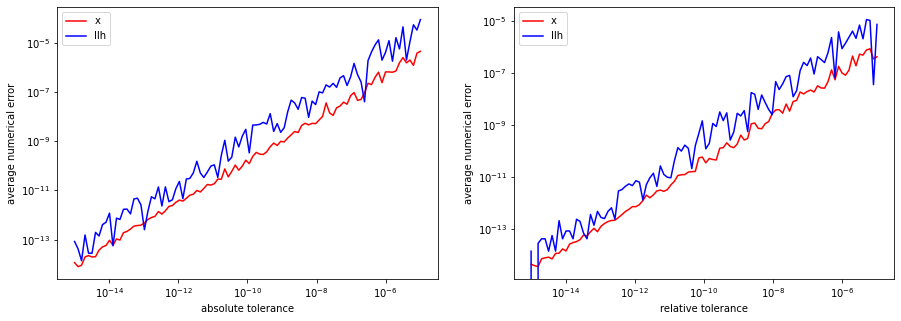

In [17]:
solver.setRelativeTolerance(1e-16)
solver.setAbsoluteTolerance(1e-16)
solver.setSensitivityOrder(amici.SensitivityOrder.none)
rdata_ref = amici.runAmiciSimulation(model, solver, edata)

def get_simulation_error(solver):
    rdata = amici.runAmiciSimulation(model, solver, edata)
    return np.mean(np.abs(rdata['x']-rdata_ref['x'])), np.mean(np.abs(rdata['llh']-rdata_ref['llh']))
    
def get_errors(tolfun, tols):
    solver.setRelativeTolerance(1e-16)
    solver.setAbsoluteTolerance(1e-16)
    x_errs = []
    llh_errs = []
    for tol in tols:
        getattr(solver, tolfun)(tol)
        x_err, llh_err = get_simulation_error(solver)
        x_errs.append(x_err)
        llh_errs.append(llh_err)
    return x_errs, llh_errs
    
atols = np.logspace(-5,-15, 100)
atol_x_errs, atol_llh_errs = get_errors('setAbsoluteTolerance', atols)

rtols = np.logspace(-5,-15, 100)
rtol_x_errs, rtol_llh_errs = get_errors('setRelativeTolerance', rtols)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

def plot_error(tols, x_errs, llh_errs, tolname, ax):
    ax.plot(tols, x_errs, 'r-', label='x')
    ax.plot(tols, llh_errs, 'b-', label='llh')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f'{tolname} tolerance')
    ax.set_ylabel('average numerical error')
    ax.legend()

plot_error(atols, atol_x_errs, atol_llh_errs, 'absolute', axes[0])
plot_error(rtols, rtol_x_errs, rtol_llh_errs, 'relative', axes[1])

# reset relative tolerance to default value
solver.setRelativeTolerance(1e-8)
solver.setRelativeTolerance(1e-16)

## Sensitivity analysis

AMICI can provide first- and second-order sensitivities using the forward- or adjoint-method. The respective options are set on the Model and Solver objects.

### Forward sensitivity analysis

In [18]:
model = model_module.getModel()
model.setTimepoints(np.linspace(0, 10, 11)) 
model.requireSensitivitiesForAllParameters()              # sensitivities w.r.t. all parameters
# model.setParameterList([1, 2])                          # sensitivities 
# w.r.t. the specified parameters
model.setParameterScale(amici.ParameterScaling.none)         # parameters are used as-is (not log-transformed)

solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod.forward)        # forward sensitivity analysis
solver.setSensitivityOrder(amici.SensitivityOrder.first) # first-order sensitivities

rdata = amici.runAmiciSimulation(model, solver)

# print sensitivity-related results
for key, value in rdata.items():
    if key.startswith('s'):
        print('%12s: ' % key, value)

          sx:  [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-2.00747250e-01  1.19873139e-01 -9.44167985e-03]
  [-1.02561396e-01 -1.88820454e-01  1.01855972e-01]
  [ 4.66193077e-01 -2.86365372e-01  2.39662449e-02]
  [ 4.52560294e-02  1.14631370e-01 -3.34067919e-02]
  [ 4.00672911e-01  1.92564093e-01  4.98877759e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-2.23007240e-01  1.53979022e-01 -1.26885280e-02]
  [-1.33426939e-01 -3.15955239e-01  9.49575030e-02]
  [ 5.03470377e-01 -3.52731535e-01  2.8156741

## Adjoint sensitivity analysis

In [19]:
# Set model options
model = model_module.getModel()
p_orig = np.array(model.getParameters())
p_orig[list(model.getParameterIds()).index('observable_x1withsigma_sigma')] = 0.1 # Change default parameter
model.setParameters(p_orig.flatten())
model.setParameterScale(amici.ParameterScaling.none)
model.setTimepoints(np.linspace(0, 10, 21)) 

solver = model.getSolver()
solver.setMaxSteps(10**4) # Set maximum number of steps for the solver

# simulate time-course to get artificial data
rdata = amici.runAmiciSimulation(model, solver)
edata = amici.ExpData(rdata, 1.0, 0)
edata.fixedParameters = model.getFixedParameters()
# set sigma to 1.0 except for observable 5, so that p[7] is used instead
# (if we have sigma parameterized, the corresponding ExpData entries must NaN, otherwise they will override the parameter)
edata.setObservedDataStdDev(rdata['t']*0+np.nan,
                            list(model.getObservableIds()).index('observable_x1withsigma'))

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder.first) # First-order ...
solver.setSensitivityMethod(amici.SensitivityMethod.adjoint)        # ... adjoint sensitivities
model.requireSensitivitiesForAllParameters()              # ... w.r.t. all parameters

# compute adjoint sensitivities
rdata = amici.runAmiciSimulation(model, solver, edata)
#print(rdata['sigmay'])
print('Log-likelihood: %f\nGradient: %s' % (rdata['llh'], rdata['sllh']))


Log-likelihood: -1782.069948
Gradient: [ 1.88753631e+01  2.34371294e+01 -4.34446460e+01 -5.65142354e+00
 -1.05291555e+02  5.87696815e-01 -2.16000777e+00  3.30558521e+04]


## Finite differences gradient check

Compare AMICI-computed gradient with finite differences

In [20]:
from scipy.optimize import check_grad

def func(x0, symbol='llh', x0full=None, plist=[], verbose=False):
    p = x0[:]
    if len(plist):
        p = x0full[:]
        p[plist] = x0
    verbose and print('f: p=%s' % p)
    
    old_parameters = model.getParameters()
    solver.setSensitivityOrder(amici.SensitivityOrder.none)
    model.setParameters(p)
    rdata = amici.runAmiciSimulation(model, solver, edata)
    
    model.setParameters(old_parameters)
    
    res = np.sum(rdata[symbol])
    verbose and print(res)
    return res

def grad(x0, symbol='llh', x0full=None, plist=[], verbose=False):
    p = x0[:]
    if len(plist):
        model.setParameterList(plist)
        p = x0full[:]
        p[plist] = x0
    else:
        model.requireSensitivitiesForAllParameters()
    verbose and print('g: p=%s' % p)
    
    old_parameters = model.getParameters()
    solver.setSensitivityMethod(amici.SensitivityMethod.forward)
    solver.setSensitivityOrder(amici.SensitivityOrder.first)
    model.setParameters(p)
    rdata = amici.runAmiciSimulation(model, solver, edata)
    
    model.setParameters(old_parameters)

    res = rdata['s%s' % symbol]
    if not isinstance(res, float):
        if len(res.shape) == 3:
            res = np.sum(res, axis=(0, 2))
    verbose and print(res)
    return res

epsilon = 1e-4
err_norm = check_grad(func, grad, p_orig, 'llh', epsilon=epsilon)
print('sllh: |error|_2: %f' % err_norm)
# assert err_norm < 1e-6
print()

for ip in range(model.np()):
    plist = [ip]
    p = p_orig.copy()
    err_norm = check_grad(func, grad, p[plist], 'llh', p, [ip], epsilon=epsilon)
    print('sllh: p[%d]: |error|_2: %f' % (ip, err_norm))

print()
for ip in range(model.np()):
    plist = [ip]
    p = p_orig.copy()
    err_norm = check_grad(func, grad, p[plist], 'y', p, [ip], epsilon=epsilon)
    print('sy: p[%d]: |error|_2: %f' % (ip, err_norm))

print()
for ip in range(model.np()):
    plist = [ip]
    p = p_orig.copy()
    err_norm = check_grad(func, grad, p[plist], 'x', p, [ip], epsilon=epsilon)
    print('sx: p[%d]: |error|_2: %f' % (ip, err_norm))

print()
for ip in range(model.np()):
    plist = [ip]
    p = p_orig.copy()
    err_norm = check_grad(func, grad, p[plist], 'sigmay', p, [ip], epsilon=epsilon)
    print('ssigmay: p[%d]: |error|_2: %f' % (ip, err_norm))


sllh: |error|_2: 49.727388

sllh: p[0]: |error|_2: 0.015277
sllh: p[1]: |error|_2: 0.013750
sllh: p[2]: |error|_2: 0.012565
sllh: p[3]: |error|_2: 0.015211
sllh: p[4]: |error|_2: 0.047226
sllh: p[5]: |error|_2: 0.000280
sllh: p[6]: |error|_2: 0.001050
sllh: p[7]: |error|_2: 49.727399

sy: p[0]: |error|_2: 0.002974
sy: p[1]: |error|_2: 0.002717
sy: p[2]: |error|_2: 0.001308
sy: p[3]: |error|_2: 0.000939
sy: p[4]: |error|_2: 0.006106
sy: p[5]: |error|_2: 0.000000
sy: p[6]: |error|_2: 0.000000
sy: p[7]: |error|_2: 0.000000

sx: p[0]: |error|_2: 0.001033
sx: p[1]: |error|_2: 0.001076
sx: p[2]: |error|_2: 0.000121
sx: p[3]: |error|_2: 0.000439
sx: p[4]: |error|_2: 0.001569
sx: p[5]: |error|_2: 0.000000
sx: p[6]: |error|_2: 0.000000
sx: p[7]: |error|_2: 0.000000

ssigmay: p[0]: |error|_2: 0.000000
ssigmay: p[1]: |error|_2: 0.000000
ssigmay: p[2]: |error|_2: 0.000000
ssigmay: p[3]: |error|_2: 0.000000
ssigmay: p[4]: |error|_2: 0.000000
ssigmay: p[5]: |error|_2: 0.000000
ssigmay: p[6]: |error|

In [21]:
eps=1e-4
op=model.getParameters()


solver.setSensitivityMethod(amici.SensitivityMethod.forward) # forward sensitivity analysis
solver.setSensitivityOrder(amici.SensitivityOrder.first) # first-order sensitivities
model.requireSensitivitiesForAllParameters()
solver.setRelativeTolerance(1e-12)
rdata = amici.runAmiciSimulation(model, solver, edata)

def fd(x0, ip, eps, symbol='llh'):
    p = list(x0[:])
    old_parameters = model.getParameters()
    solver.setSensitivityOrder(amici.SensitivityOrder.none)
    p[ip]+=eps
    model.setParameters(p)
    rdata_f = amici.runAmiciSimulation(model, solver, edata)
    p[ip]-=2*eps
    model.setParameters(p)
    rdata_b = amici.runAmiciSimulation(model, solver, edata)
    
    model.setParameters(old_parameters)
    return (rdata_f[symbol]-rdata_b[symbol])/(2*eps)

def plot_sensitivities(symbol, eps):
    fig, axes = plt.subplots(4,2, figsize=(15,10))
    for ip in range(4):
        fd_approx = fd(model.getParameters(), ip, eps, symbol=symbol)

        axes[ip,0].plot(edata.getTimepoints(), rdata[f's{symbol}'][:,ip,:], 'r-')
        axes[ip,0].plot(edata.getTimepoints(), fd_approx, 'k--')
        axes[ip,0].set_ylabel(f'sensitivity {symbol}')
        axes[ip,0].set_xlabel('time')


        axes[ip,1].plot(edata.getTimepoints(), np.abs(rdata[f's{symbol}'][:,ip,:]-fd_approx), 'k-')
        axes[ip,1].set_ylabel('difference to fd')
        axes[ip,1].set_xlabel('time')
        axes[ip,1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

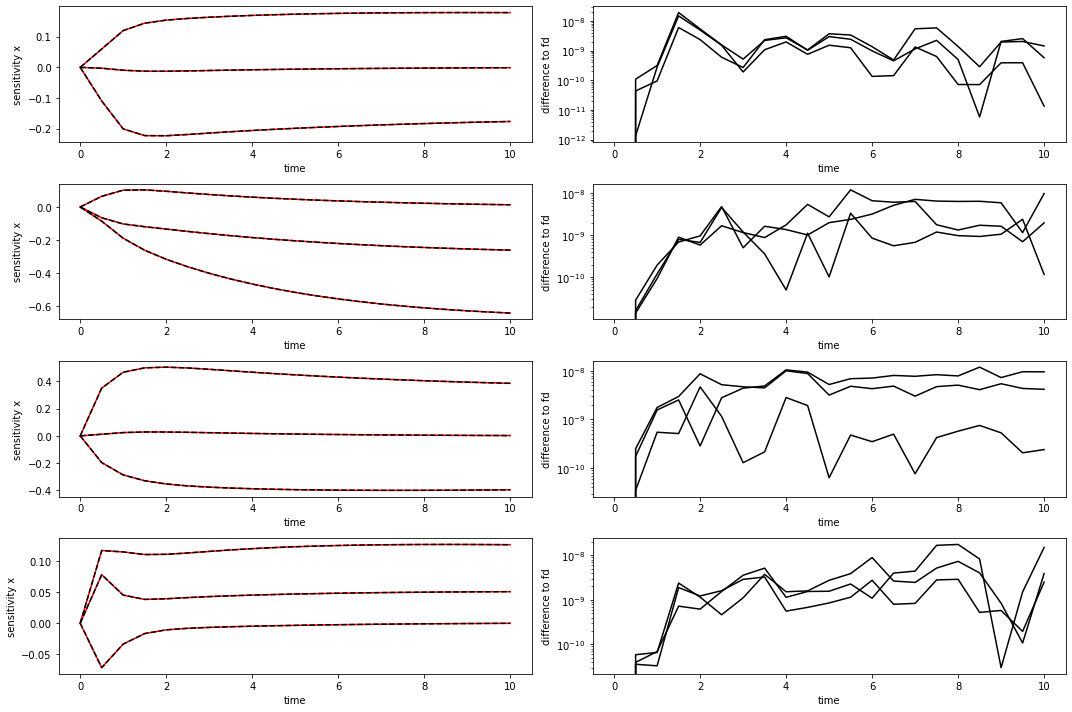

In [22]:
plot_sensitivities('x', eps)

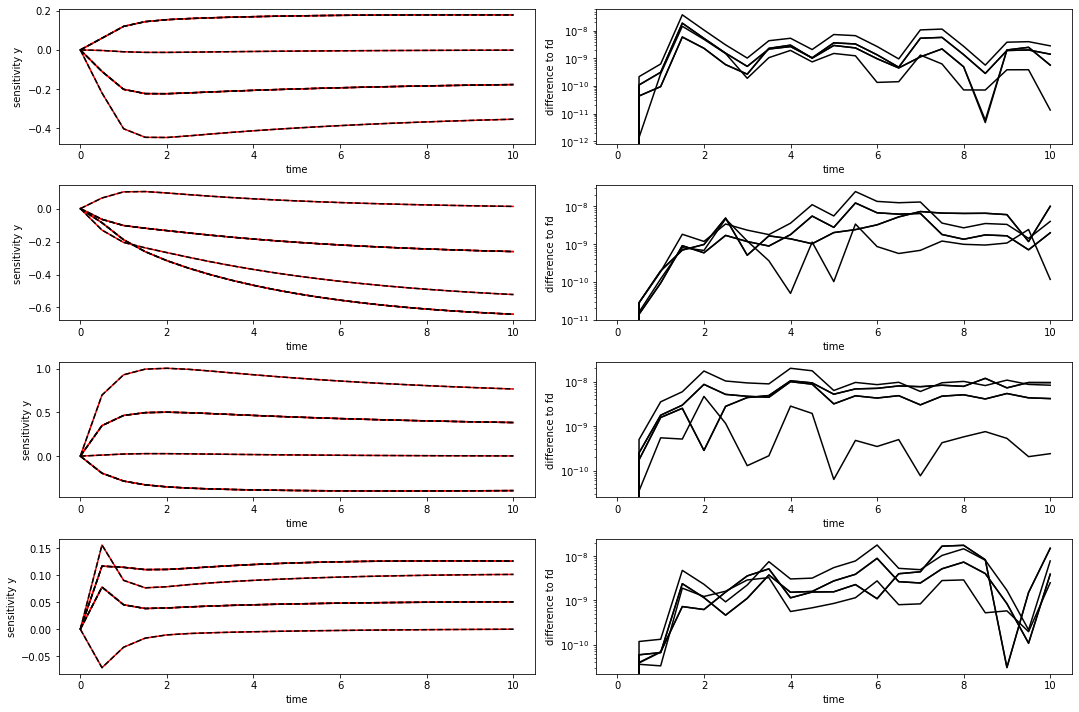

In [23]:
plot_sensitivities('y', eps)

## Export as DataFrame

Experimental data and simulation results can both be exported as pandas Dataframe to allow for an easier inspection of numeric values

In [24]:
# run the simulation
rdata = amici.runAmiciSimulation(model, solver, edata)

In [25]:
# look at the ExpData as DataFrame 
df = amici.getDataObservablesAsDataFrame(model, [edata])
df

,time,datatype,t_presim,k0,k0_preeq,k0_presim,observable_x1,observable_x2,observable_x3,observable_x1_scaled,observable_x2_offsetted,observable_x1withsigma,observable_x1_std,observable_x2_std,observable_x3_std,observable_x1_scaled_std,observable_x2_offsetted_std,observable_x1withsigma_std
0,0.0,data,0.0,1.0,NaN,NaN,-1.818394,0.323750,-1.130396,-0.235845,3.003267,-1.249817,1.0,1.0,1.0,1.0,1.0,NaN
1,0.5,data,0.0,1.0,NaN,NaN,-0.286706,1.481899,-0.190653,0.384839,3.928552,0.322567,1.0,1.0,1.0,1.0,1.0,NaN
2,1.0,data,0.0,1.0,NaN,NaN,-0.112492,1.481440,0.010955,1.837763,3.394742,0.547032,1.0,1.0,1.0,1.0,1.0,NaN
3,1.5,data,0.0,1.0,NaN,NaN,0.836740,1.890309,0.855302,1.396028,3.634490,1.340781,1.0,1.0,1.0,1.0,1.0,NaN
4,2.0,data,0.0,1.0,NaN,NaN,0.233868,1.963070,-0.356165,1.342368,3.063575,-1.318266,1.0,1.0,1.0,1.0,1.0,NaN
5,2.5,data,0.0,1.0,NaN,NaN,0.915582,-0.012158,0.380968,1.772030,2.638614,1.998935,1.0,1.0,1.0,1.0,1.0,NaN
6,3.0,data,0.0,1.0,NaN,NaN,0.919766,0.240276,0.012171,0.072701,3.251369,-0.546210,1.0,1.0,1.0,1.0,1.0,NaN
7,3.5,data,0.0,1.0,NaN,NaN,0.166633,1.250029,-0.248000,2.575797,5.000227,3.267072,1.0,1.0,1.0,1.0,1.0,NaN
8,4.0,data,0.0,1.0,NaN,NaN,0.638798,1.308206,-1.515860,1.361921,1.807606,0.022304,1.0,1.0,1.0,1.0,1.0,NaN
9,4.5,data,0.0,1.0,NaN,NaN,0.187986,-0.482633,0.326894,1.982838,2.642325,-0.265486,1.0,1.0,1.0,1.0,1.0,NaN


In [26]:
# from the exported dataframe, we can actually reconstruct a copy of the ExpData instace
reconstructed_edata = amici.getEdataFromDataFrame(model, df)

In [27]:
# look at the States in rdata as DataFrame 
amici.getResidualsAsDataFrame(model, [edata], [rdata])

,time,t_presim,k0,k0_preeq,k0_presim,observable_x1,observable_x2,observable_x3,observable_x1_scaled,observable_x2_offsetted,observable_x1withsigma
0,0.0,0.0,1.0,NaN,NaN,1.918394,0.076250,1.830396,0.435845,0.396733,13.498166
1,0.5,0.0,1.0,NaN,NaN,0.826073,0.797220,0.382144,0.693896,0.243874,2.168002
2,1.0,0.0,1.0,NaN,NaN,0.692564,0.748152,0.085469,0.677618,0.338545,0.330408
3,1.5,0.0,1.0,NaN,NaN,0.266340,1.159657,0.779226,0.255229,0.096162,7.703818
4,2.0,0.0,1.0,NaN,NaN,0.326667,1.247234,0.425859,0.221299,0.652261,18.788001
5,2.5,0.0,1.0,NaN,NaN,0.362526,0.710908,0.314667,0.665919,1.060136,14.458795
6,3.0,0.0,1.0,NaN,NaN,0.372895,0.441686,0.051562,1.021041,0.430593,10.930802
7,3.5,0.0,1.0,NaN,NaN,0.374727,0.583920,0.309506,1.493077,1.334118,27.257116
8,4.0,0.0,1.0,NaN,NaN,0.102518,0.656904,1.575355,0.289360,1.843696,5.139764
9,4.5,0.0,1.0,NaN,NaN,0.343553,1.120148,0.269241,0.919762,0.995190,7.970237


In [28]:
# look at the Observables in rdata as DataFrame 
amici.getSimulationObservablesAsDataFrame(model, [edata], [rdata])

,time,datatype,t_presim,k0,k0_preeq,k0_presim,observable_x1,observable_x2,observable_x3,observable_x1_scaled,observable_x2_offsetted,observable_x1withsigma,observable_x1_std,observable_x2_std,observable_x3_std,observable_x1_scaled_std,observable_x2_offsetted_std,observable_x1withsigma_std
0,0.0,simulation,0.0,1.0,NaN,NaN,0.100000,0.400000,0.700000,0.200000,3.400000,0.100000,1.0,1.0,1.0,1.0,1.0,0.1
1,0.5,simulation,0.0,1.0,NaN,NaN,0.539367,0.684679,0.191491,1.078734,3.684679,0.539367,1.0,1.0,1.0,1.0,1.0,0.1
2,1.0,simulation,0.0,1.0,NaN,NaN,0.580072,0.733287,0.096424,1.160145,3.733287,0.580072,1.0,1.0,1.0,1.0,1.0,0.1
3,1.5,simulation,0.0,1.0,NaN,NaN,0.570399,0.730652,0.076076,1.140799,3.730652,0.570399,1.0,1.0,1.0,1.0,1.0,0.1
4,2.0,simulation,0.0,1.0,NaN,NaN,0.560535,0.715836,0.069694,1.121069,3.715836,0.560535,1.0,1.0,1.0,1.0,1.0,0.1
5,2.5,simulation,0.0,1.0,NaN,NaN,0.553056,0.698751,0.066301,1.106112,3.698751,0.553056,1.0,1.0,1.0,1.0,1.0,0.1
6,3.0,simulation,0.0,1.0,NaN,NaN,0.546871,0.681963,0.063733,1.093741,3.681963,0.546871,1.0,1.0,1.0,1.0,1.0,0.1
7,3.5,simulation,0.0,1.0,NaN,NaN,0.541360,0.666109,0.061506,1.082720,3.666109,0.541360,1.0,1.0,1.0,1.0,1.0,0.1
8,4.0,simulation,0.0,1.0,NaN,NaN,0.536280,0.651302,0.059495,1.072561,3.651302,0.536280,1.0,1.0,1.0,1.0,1.0,0.1
9,4.5,simulation,0.0,1.0,NaN,NaN,0.531538,0.637515,0.057653,1.063076,3.637515,0.531538,1.0,1.0,1.0,1.0,1.0,0.1


In [29]:
# look at the States in rdata as DataFrame 
amici.getSimulationStatesAsDataFrame(model, [edata], [rdata])

,time,t_presim,k0,k0_preeq,k0_presim,x1,x2,x3
0,0.0,0.0,1.0,NaN,NaN,0.100000,0.400000,0.700000
1,0.5,0.0,1.0,NaN,NaN,0.539367,0.684679,0.191491
2,1.0,0.0,1.0,NaN,NaN,0.580072,0.733287,0.096424
3,1.5,0.0,1.0,NaN,NaN,0.570399,0.730652,0.076076
4,2.0,0.0,1.0,NaN,NaN,0.560535,0.715836,0.069694
5,2.5,0.0,1.0,NaN,NaN,0.553056,0.698751,0.066301
6,3.0,0.0,1.0,NaN,NaN,0.546871,0.681963,0.063733
7,3.5,0.0,1.0,NaN,NaN,0.541360,0.666109,0.061506
8,4.0,0.0,1.0,NaN,NaN,0.536280,0.651302,0.059495
9,4.5,0.0,1.0,NaN,NaN,0.531538,0.637515,0.057653
